# Quick Draw Modified CNN
Abel Tadesse <br />
Jason Yi <br />
Richy Chen <br />

## Import dependencies 

In [1]:
%reset -f 
import os
import re
from glob import glob
from tqdm import tqdm
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
%matplotlib inline

How the training data looks: The data frame is a concatenation of 2 rows from each CSV file in the training set.


In [2]:
fnames = glob('./../train_simplified/*.csv')
cnames = ['countrycode', 'drawing', 'key_id', 'recognized', 'timestamp', 'word']
drawlist = []
for f in fnames[0:6]:
    first = pd.read_csv(f, nrows=10) # make sure we get a recognized drawing
    first = first[first.recognized==True].head(2)
    drawlist.append(first)
draw_df = pd.DataFrame(np.concatenate(drawlist), columns=cnames)
draw_df

,countrycode,drawing,key_id,recognized,timestamp,word
0,MD,"[[[41, 41, 49, 41, 42], [76, 110, 157, 201, 25...",5042528606748672,True,2017-03-11 21:58:33.282340,lollipop
1,FI,"[[[61, 65, 67], [98, 106, 255]], [[72, 66, 56,...",5232288554024960,True,2017-01-25 14:49:39.148020,lollipop
2,US,"[[[122, 102, 56, 45, 66], [0, 3, 3, 29, 22]], ...",5570004864991232,True,2017-03-16 05:55:20.812240,bench
3,AU,"[[[2, 1, 11, 101, 234, 250, 255], [70, 43, 16,...",5906426784382976,True,2017-03-10 05:48:45.775800,bench
4,US,"[[[0, 11, 14, 14, 7, 8, 14, 155, 187, 205, 210...",6320925102309376,True,2017-03-29 20:51:33.924090,dresser
5,VN,"[[[19, 15, 16, 23, 72, 138, 178, 182, 181, 189...",5963662059634688,True,2017-01-31 05:36:18.230000,dresser
6,AU,"[[[96, 84, 84, 101, 112, 115, 110, 103, 91, 86...",5212908118081536,True,2017-01-18 03:19:25.996870,scorpion
7,US,"[[[34, 19], [186, 223]], [[44, 47, 47, 41], [1...",6378657540997120,True,2017-03-30 20:32:16.099910,scorpion
8,BE,"[[[20, 12, 0, 1, 18, 24, 26, 25, 19], [134, 13...",4702418350637056,True,2017-03-26 21:51:40.742850,tractor
9,DE,"[[[125, 123, 107, 83, 54, 28, 6, 0, 2, 17, 42,...",4543922971869184,True,2017-01-26 19:32:14.264860,tractor


Example of how the sketches look:

In [3]:
evens = range(0,11,2)
odds = range(1,12, 2)
df1 = draw_df[draw_df.index.isin(evens)]
df2 = draw_df[draw_df.index.isin(odds)]

example1s = [ast.literal_eval(pts) for pts in df1.drawing.values]
example2s = [ast.literal_eval(pts) for pts in df2.drawing.values]

/home/abelleulseged/.local/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


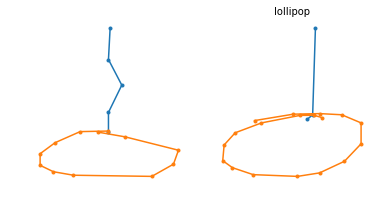

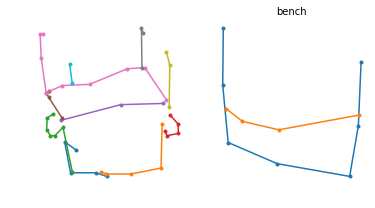

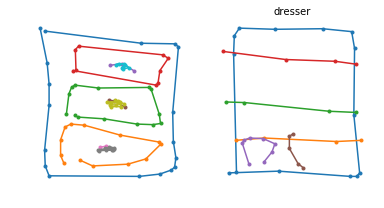

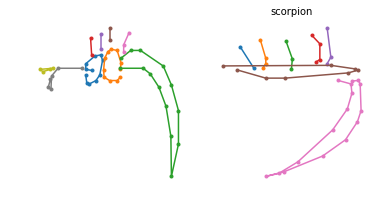

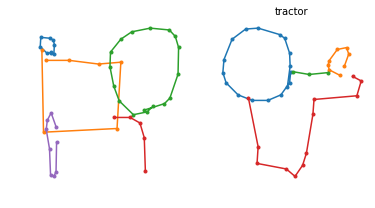

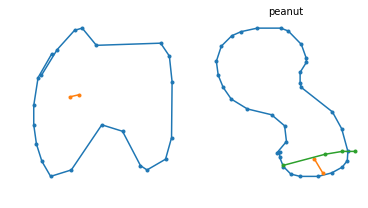

In [4]:
labels = df2.word.tolist()
for i, example in enumerate(example1s):
    plt.figure(figsize=(6,3))
    
    for x,y in example:
        plt.subplot(1,2,1)
        plt.plot(x, y, marker='.')
        plt.axis('off')

    for x,y, in example2s[i]:
        plt.subplot(1,2,2)
        plt.plot(x, y, marker='.')
        plt.axis('off')
        label = labels[i]
        plt.title(label, fontsize=10)

    plt.show()  

## Convolutional Neural Network (CNN) Implementation
Essentially an image classifier. Interprets the data as a 2D object with the strokes at completion. 


In [5]:
#%% import
import os
from glob import glob
import re
import ast
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw 
from tqdm import tqdm
from dask import bag

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.metrics import top_k_categorical_accuracy
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [6]:
#%% set label dictionary and params
classfiles = os.listdir('./../train_simplified/')
numstonames = {i: v[:-4].replace(" ", "_") for i, v in enumerate(classfiles)} #adds underscores

num_classes = 340
imheight, imwidth = 32, 32  
ims_per_class = 2000  #max?

In [7]:
# faster conversion function
# Use PIL to make it faster to draw images
def draw_it(strokes):
    image = Image.new("P", (256,256), color=255)
    image_draw = ImageDraw.Draw(image)
    for stroke in ast.literal_eval(strokes):
        for i in range(len(stroke[0])-1):
            image_draw.line([stroke[0][i], 
                             stroke[1][i],
                             stroke[0][i+1], 
                             stroke[1][i+1]],
                            fill=0, width=5)
    image = image.resize((imheight, imwidth))
    return np.array(image)/255.

#%% get train arrays
# train = all drawings of that label
# trainarray = array representation of all those drawings in the label
# train_grand = list of list accumulator for all the array representations of drawings. 
train_grand = []
class_paths = glob('./../train_simplified/*.csv')
np.random.shuffle(class_paths)

In [8]:
for i,c in enumerate(tqdm(class_paths[0: num_classes])):
    #look at drawing and recognized columns
    train = pd.read_csv(c, usecols=['drawing', 'recognized'], nrows=ims_per_class*5//4)
    train = train[train.recognized == True].head(ims_per_class)
    # draws out the drawing values 
    imagebag = bag.from_sequence(train.drawing.values).map(draw_it) 
    # draw them at same time into np array
    trainarray = np.array(imagebag.compute())  
    trainarray = np.reshape(trainarray, (ims_per_class, -1))   
    # has all the label names for that specific label
    labelarray = np.full((train.shape[0], 1), i)
    # merge the labels and the drawings at every iteration and then stick it in one huge array
    trainarray = np.concatenate((labelarray, trainarray), axis=1)
    train_grand.append(trainarray)
    
train_grand = np.array([train_grand.pop() for i in np.arange(num_classes)]) #less memory than np.concatenate
train_grand = train_grand.reshape((-1, (imheight*imwidth+1)))

del trainarray
del train

100%|██████████| 340/340 [08:04<00:00,  1.74s/it]


In [9]:
# memory-friendly alternative to train_test_split?
# write the cut off point for splitting data between train and validation
valfrac = 0.1
cutpt = int(valfrac * train_grand.shape[0])

# shuffle the train_grand randomly
np.random.shuffle(train_grand)
# train gets last 90% and validation gets first 10%
# y represents the label (output) and the x represents the drawn image
y_train, X_train = train_grand[cutpt: , 0], train_grand[cutpt: , 1:]
y_val, X_val = train_grand[0:cutpt, 0], train_grand[0:cutpt, 1:] #validation set is recognized==True

del train_grand

# Encode labels with value between 0 and n_classes-1
y_train = keras.utils.to_categorical(y_train, num_classes)
# reshape the drawings to pixels
X_train = X_train.reshape(X_train.shape[0], imheight, imwidth, 1)
y_val = keras.utils.to_categorical(y_val, num_classes)
X_val = X_val.reshape(X_val.shape[0], imheight, imwidth, 1)

print(y_train.shape, "\n",
      X_train.shape, "\n",
      y_val.shape, "\n",
      X_val.shape)

(612000, 340) 
 (612000, 32, 32, 1) 
 (68000, 340) 
 (68000, 32, 32, 1)


# CNN architecture

In [10]:
model = Sequential()
# begin with 2D convolutional error instead of dense layer to prevent loss of spatial information
model.add(Conv2D(30, (5, 5), input_shape=(imheight, imwidth, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(15, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

# Dropout to account for possible overfitting
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 30)        780       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 30)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 15)        4065      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 15)          0         
_________________________________________________________________
flatten (Flatten)            (None, 540)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               69248     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
__________

In [11]:
def top_3_accuracy(x,y): 
    t3 = top_k_categorical_accuracy(x,y, 3)
    return t3
# save weights as you go and make checkpoint when value is better
weight_path="./{}_weights.hdf5".format('modified_cnn_model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)
# monitor validation loss
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, 
                                   verbose=1, mode='auto', min_delta=0.005, cooldown=5, min_lr=0.0001)
earlystop = EarlyStopping(monitor='val_top_3_accuracy', mode='max', patience=20) 
# while training, make these calls
callbacks = [reduceLROnPlat, earlystop, checkpoint]

In [12]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', top_3_accuracy])

In [13]:
history = model.fit(x=X_train, y=y_train,
          batch_size = 4096,
          epochs = 100,
          validation_data = (X_val, y_val),
          callbacks = callbacks,
          verbose = 1)

Train on 612000 samples, validate on 68000 samples
Epoch 1/100
610304/612000 [============================>.] - ETA: 0s - loss: 5.3415 - acc: 0.0237 - top_3_accuracy: 0.0595
Epoch 00001: val_loss improved from inf to 4.68236, saving model to ./modified_cnn_model_weights.hdf5

Consider using a TensorFlow optimizer from `tf.train`.
612000/612000 [==============================] - 30s 49us/step - loss: 5.3401 - acc: 0.0238 - top_3_accuracy: 0.0597 - val_loss: 4.6824 - val_acc: 0.0814 - val_top_3_accuracy: 0.1734
Epoch 2/100
610304/612000 [============================>.] - ETA: 0s - loss: 4.6135 - acc: 0.0756 - top_3_accuracy: 0.1662
Epoch 00002: val_loss improved from 4.68236 to 4.22251, saving model to ./modified_cnn_model_weights.hdf5

Consider using a TensorFlow optimizer from `tf.train`.
612000/612000 [==============================] - 21s 34us/step - loss: 4.6131 - acc: 0.0756 - top_3_accuracy: 0.1662 - val_loss: 4.2225 - val_acc: 0.1313 - val_top_3_accuracy: 0.2559
Epoch 3/100
61030

610304/612000 [============================>.] - ETA: 0s - loss: 3.5089 - acc: 0.2150 - top_3_accuracy: 0.3913
Epoch 00011: val_loss improved from 3.13951 to 3.09123, saving model to ./modified_cnn_model_weights.hdf5

Consider using a TensorFlow optimizer from `tf.train`.
612000/612000 [==============================] - 21s 34us/step - loss: 3.5089 - acc: 0.2151 - top_3_accuracy: 0.3913 - val_loss: 3.0912 - val_acc: 0.2991 - val_top_3_accuracy: 0.4992
Epoch 12/100
610304/612000 [============================>.] - ETA: 0s - loss: 3.4712 - acc: 0.2211 - top_3_accuracy: 0.3994
Epoch 00012: val_loss improved from 3.09123 to 3.05251, saving model to ./modified_cnn_model_weights.hdf5

Consider using a TensorFlow optimizer from `tf.train`.
612000/612000 [==============================] - 20s 33us/step - loss: 3.4711 - acc: 0.2211 - top_3_accuracy: 0.3994 - val_loss: 3.0525 - val_acc: 0.3077 - val_top_3_accuracy: 0.5068
Epoch 13/100
610304/612000 [============================>.] - ETA: 0s - los

612000/612000 [==============================] - 20s 33us/step - loss: 3.2695 - acc: 0.2549 - top_3_accuracy: 0.4440 - val_loss: 2.8256 - val_acc: 0.3455 - val_top_3_accuracy: 0.5545
Epoch 22/100
610304/612000 [============================>.] - ETA: 0s - loss: 3.2595 - acc: 0.2564 - top_3_accuracy: 0.4462
Epoch 00022: val_loss improved from 2.82562 to 2.82284, saving model to ./modified_cnn_model_weights.hdf5

Consider using a TensorFlow optimizer from `tf.train`.
612000/612000 [==============================] - 20s 33us/step - loss: 3.2595 - acc: 0.2563 - top_3_accuracy: 0.4462 - val_loss: 2.8228 - val_acc: 0.3472 - val_top_3_accuracy: 0.5545
Epoch 23/100
610304/612000 [============================>.] - ETA: 0s - loss: 3.2497 - acc: 0.2580 - top_3_accuracy: 0.4481
Epoch 00023: val_loss improved from 2.82284 to 2.81010, saving model to ./modified_cnn_model_weights.hdf5

Consider using a TensorFlow optimizer from `tf.train`.
612000/612000 [==============================] - 20s 33us/step

612000/612000 [==============================] - 20s 33us/step - loss: 3.1692 - acc: 0.2716 - top_3_accuracy: 0.4653 - val_loss: 2.7177 - val_acc: 0.3652 - val_top_3_accuracy: 0.5756
Epoch 33/100
610304/612000 [============================>.] - ETA: 0s - loss: 3.1600 - acc: 0.2724 - top_3_accuracy: 0.4672
Epoch 00033: val_loss improved from 2.71771 to 2.70233, saving model to ./modified_cnn_model_weights.hdf5

Consider using a TensorFlow optimizer from `tf.train`.
612000/612000 [==============================] - 20s 33us/step - loss: 3.1599 - acc: 0.2725 - top_3_accuracy: 0.4672 - val_loss: 2.7023 - val_acc: 0.3689 - val_top_3_accuracy: 0.5777
Epoch 34/100
610304/612000 [============================>.] - ETA: 0s - loss: 3.1523 - acc: 0.2735 - top_3_accuracy: 0.4689
Epoch 00034: val_loss did not improve from 2.70233
612000/612000 [==============================] - 20s 33us/step - loss: 3.1522 - acc: 0.2735 - top_3_accuracy: 0.4689 - val_loss: 2.7281 - val_acc: 0.3664 - val_top_3_accurac

612000/612000 [==============================] - 20s 33us/step - loss: 3.0874 - acc: 0.2855 - top_3_accuracy: 0.4832 - val_loss: 2.6400 - val_acc: 0.3801 - val_top_3_accuracy: 0.5913
Epoch 47/100
610304/612000 [============================>.] - ETA: 0s - loss: 3.0875 - acc: 0.2857 - top_3_accuracy: 0.4826
Epoch 00047: val_loss improved from 2.64005 to 2.63802, saving model to ./modified_cnn_model_weights.hdf5

Consider using a TensorFlow optimizer from `tf.train`.
612000/612000 [==============================] - 21s 34us/step - loss: 3.0876 - acc: 0.2857 - top_3_accuracy: 0.4825 - val_loss: 2.6380 - val_acc: 0.3786 - val_top_3_accuracy: 0.5874
Epoch 48/100
610304/612000 [============================>.] - ETA: 0s - loss: 3.0809 - acc: 0.2864 - top_3_accuracy: 0.4845
Epoch 00048: val_loss improved from 2.63802 to 2.63128, saving model to ./modified_cnn_model_weights.hdf5

Consider using a TensorFlow optimizer from `tf.train`.
612000/612000 [==============================] - 21s 34us/step

Epoch 61/100
610304/612000 [============================>.] - ETA: 0s - loss: 3.0435 - acc: 0.2931 - top_3_accuracy: 0.4927
Epoch 00061: val_loss did not improve from 2.58940
612000/612000 [==============================] - 21s 34us/step - loss: 3.0433 - acc: 0.2931 - top_3_accuracy: 0.4927 - val_loss: 2.5947 - val_acc: 0.3867 - val_top_3_accuracy: 0.6001
Epoch 62/100
610304/612000 [============================>.] - ETA: 0s - loss: 3.0383 - acc: 0.2931 - top_3_accuracy: 0.4940
Epoch 00062: val_loss improved from 2.58940 to 2.58633, saving model to ./modified_cnn_model_weights.hdf5

Consider using a TensorFlow optimizer from `tf.train`.
612000/612000 [==============================] - 21s 34us/step - loss: 3.0385 - acc: 0.2931 - top_3_accuracy: 0.4940 - val_loss: 2.5863 - val_acc: 0.3896 - val_top_3_accuracy: 0.6016
Epoch 63/100
610304/612000 [============================>.] - ETA: 0s - loss: 3.0358 - acc: 0.2941 - top_3_accuracy: 0.4941
Epoch 00063: val_loss did not improve from 2.5863

612000/612000 [==============================] - 21s 34us/step - loss: 3.0049 - acc: 0.2995 - top_3_accuracy: 0.5013 - val_loss: 2.5561 - val_acc: 0.3941 - val_top_3_accuracy: 0.6078
Epoch 77/100
610304/612000 [============================>.] - ETA: 0s - loss: 3.0045 - acc: 0.2999 - top_3_accuracy: 0.5008
Epoch 00077: val_loss improved from 2.55606 to 2.55096, saving model to ./modified_cnn_model_weights.hdf5

Consider using a TensorFlow optimizer from `tf.train`.
612000/612000 [==============================] - 21s 34us/step - loss: 3.0044 - acc: 0.2998 - top_3_accuracy: 0.5009 - val_loss: 2.5510 - val_acc: 0.3933 - val_top_3_accuracy: 0.6075
Epoch 78/100
610304/612000 [============================>.] - ETA: 0s - loss: 3.0026 - acc: 0.3007 - top_3_accuracy: 0.5013
Epoch 00078: val_loss improved from 2.55096 to 2.55093, saving model to ./modified_cnn_model_weights.hdf5

Consider using a TensorFlow optimizer from `tf.train`.
612000/612000 [==============================] - 21s 34us/step

612000/612000 [==============================] - 21s 34us/step - loss: 2.9824 - acc: 0.3042 - top_3_accuracy: 0.5055 - val_loss: 2.5314 - val_acc: 0.3980 - val_top_3_accuracy: 0.6117
Epoch 91/100
610304/612000 [============================>.] - ETA: 0s - loss: 2.9841 - acc: 0.3030 - top_3_accuracy: 0.5054
Epoch 00091: val_loss improved from 2.53136 to 2.52806, saving model to ./modified_cnn_model_weights.hdf5

Consider using a TensorFlow optimizer from `tf.train`.
612000/612000 [==============================] - 21s 34us/step - loss: 2.9840 - acc: 0.3031 - top_3_accuracy: 0.5055 - val_loss: 2.5281 - val_acc: 0.3994 - val_top_3_accuracy: 0.6129
Epoch 92/100
610304/612000 [============================>.] - ETA: 0s - loss: 2.9838 - acc: 0.3039 - top_3_accuracy: 0.5057
Epoch 00092: val_loss did not improve from 2.52806
612000/612000 [==============================] - 21s 34us/step - loss: 2.9837 - acc: 0.3040 - top_3_accuracy: 0.5058 - val_loss: 2.5322 - val_acc: 0.3982 - val_top_3_accurac

In [14]:
model.load_weights(weight_path)

dict_keys(['val_loss', 'val_acc', 'val_top_3_accuracy', 'loss', 'acc', 'top_3_accuracy', 'lr'])


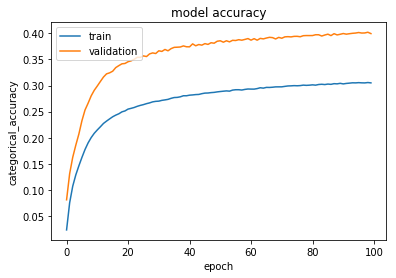

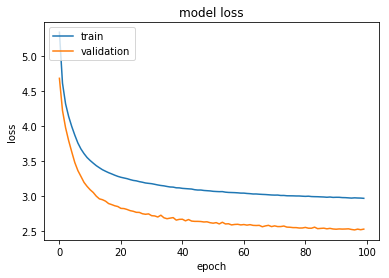

In [15]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Predictions on test set


In [16]:
#%% get test set
ttvlist = []
reader = pd.read_csv('./../test_simplified.csv', index_col=['key_id'],
    chunksize=2048)
for chunk in tqdm(reader, total=55):
    imagebag = bag.from_sequence(chunk.drawing.values).map(draw_it)
    testarray = np.array(imagebag.compute())
    testarray = np.reshape(testarray, (testarray.shape[0], imheight, imwidth, 1))
    testpreds = model.predict(testarray, verbose=0)
    ttvs = np.argsort(-testpreds)[:, 0:3]  # top 3
    ttvlist.append(ttvs)
    
ttvarray = np.concatenate(ttvlist)

100%|██████████| 55/55 [01:40<00:00,  1.81s/it]


In [17]:
preds_df = pd.DataFrame({'first': ttvarray[:,0], 'second': ttvarray[:,1], 'third': ttvarray[:,2]})
preds_df = preds_df.replace(numstonames)
preds_df['words'] = preds_df['first'] + " " + preds_df['second'] + " " + preds_df['third']

sub = pd.read_csv('./../sample_submission.csv', index_col=['key_id'])
sub['word'] = preds_df.words.values
sub.to_csv('cnn_mod.csv')
sub.head()

,word
key_id,
9000003627287624,skateboard bracelet cello
9000010688666847,star hospital shorts
9000023642890129,diamond owl crown
9000038588854897,pool panda jacket
9000052667981386,airplane headphones ear
